In [1]:
from pyswip import Prolog
from inference import *
from PIL import ImageTk, Image
from program_generation.norel_program import *
import os
import matplotlib.pyplot as plt

In [80]:
'''
Pre-process text file
* remove the \n
* remove the preceeding white space
* combine current string with the next string if i+1 does not begin with true_class
'''

# Combine lines and clean strings
def clean_theory(theory):
    clean_theory = []
    for i in range(0,len(theory)-1):
        if ':-' not in theory[i+1]:
                rule = theory[i].strip().replace('\n', '') + ' ' + theory[i+1].strip().replace('\n', '')
                clean_theory.append(rule)
    
    return clean_theory

def merge_lines(clean_theory):
    # Tidy up to ensure all rules begin with head :- body
    full_theory = []
    if len(clean_theory) > 1:
        for i in range(0,len(clean_theory)-1):
            if ':-' not in clean_theory[i+1]:
                    rule = clean_theory[i] + ' ' + clean_theory[i+1]
                    full_theory.append(rule)
            elif ':-' in clean_theory[i]:
                full_theory.append(clean_theory[i])

    else:
        full_theory = clean_theory

    return full_theory

def add_variable(full_theory):
    new_theory = []
    for rule in full_theory:
        head = 'true_class(A,EX) :-'
        body = rule.rpartition(':-')[2][:-1]

        new_body = body + ', Ex = ' + f'({body}).'
        new_clause = head + new_body

        new_theory.append(new_clause)
    
    return new_theory
    
def save_ruleset_to_prolog(dataset, filename, full_theory):
    file = open(filename, 'w')
    file.write(f":-consult('aleph_input/{dataset}_aleph.bk').\n")
    # file.write(f':-consult("test_samples.pl").\n')
    file.write("\n")

    for rule in full_theory:
        head = 'true_class(A,Ex) :-'
        body = rule.rpartition(':-')[2][:-1]

        file.write(head + "\n")
        file.write("    " + body + ",\n")
        file.write("    Ex = " + f"[{body.strip()}].\n")
        file.write("\n")

    file.close()        

def translate_theory(dataset, filename = 'working_theory.pl'):

    with open(f'{dataset}_theory.txt') as f:
        theory = f.readlines()
    
    theory = clean_theory(theory)
    theory = merge_lines(theory)
    save_ruleset_to_prolog(dataset, filename, theory)

def single_instance_inference(dataset, example_number, prolog):
    translate_theory(dataset = dataset)
    prolog.consult("working_theory.pl")
    result = list(prolog.query(f"true_class(example_{example_number}, Explanation)"))

    # Extract prediction and explanation
    if len(result) == 0:
        pred = 0
        explanation = None
    elif len(result) == 1:
        pred = 1
        explanation = result[0]['Explanation']
    else: # need to fix this - why is some len 1 and others more?
        pred = 1
        explanation = result[0]['Explanation']

    return (pred, explanation)

def add_constraint(dataset):
    output_directory = 'aleph_input'
    bk_file = open(output_directory + '/' + dataset + '_aleph.bk', 'a')

    bk_file.write(":-consult('constraints.pl').\n")
    bk_file.write("bodyList(Body, FinalList) :-\n \
        clause2list(Body,[],Output, Clause), list_to_term(Clause, Term), insertAtEnd(Term,Output,FinalList).\n")
    bk_file.write("false :- \n\
        hypothesis(_,Body,_), bodyList(Body, List), !, member(has_color(_,_), List).")
    


    bk_file.close()

def ilp_induce(dataset, prolog):

    # generate initial ILP thoery and save to a file
    prolog.consult('aleph6.pl')
    list(prolog.query(f"read_all('aleph_input/{dataset}_aleph')."))
    list(prolog.query("induce."))
    list(prolog.query(f"write_rules('{dataset}_theory.txt')."))

# Below are in the GUI_utils file

def delete_existing_constraints(dataset='hans'):
    '''Currently stored within GUI_utils'''
    lines = []
    path = f'aleph_input/{dataset}_aleph.bk'
    with open(path, 'r') as fp:
        lines = fp.readlines()
    
    # write file
    with open(path, 'w') as fp:
        for line in lines:
            if line[0:5] != 'false' and line != ":-consult('constraints.pl).\n":
                fp.write(line)


def transform_clause(og_clause):
    '''Transforms clause to natural language'''

    clause = list(set(og_clause))

    # find ALL THE first contains predicate
    contains_preds = [i for i in clause if 'contains' in i]
    nl_clause = ''
    for object_predicate in contains_preds:
        # add an "image contains an object X" sentence
        clause.remove(object_predicate)
        var = object_predicate.rpartition('contains(')[2].rpartition(', ')[0]
        nl_clause = nl_clause + f"Image contains an object {var}"

        # search for the elements in the clause containing that variable
        # for each element: add the attribute and the attribute value
        attribute_preds = [i for i in clause if var in i]
        for idx, predicate in enumerate(attribute_preds):
            attribute = predicate.rpartition('('+var)[0].rpartition('has_')[2]
            att_value = predicate.rpartition(var+', ')[2][:-1]

            if len(attribute_preds) > 1 and idx == 0:
                nl_clause = nl_clause + f" with {attribute} {att_value}"
            elif len(attribute_preds) == 1 and idx ==0:
                nl_clause = nl_clause + f" with {attribute} {att_value}. "
            elif idx+1 == len(attribute_preds) and idx > 0:
                nl_clause = nl_clause + f" and {attribute} {att_value}.\n"
            else:
                nl_clause = nl_clause + f" and {attribute} {att_value}"
            
    return nl_clause



# Test initial prolog inference with constraint

In [ ]:
# Initial theory with prediction

dataset = 'hans'
prolog = Prolog()
ilp_induce(dataset, prolog)
result1 = single_instance_inference(dataset=dataset, example_number=1, prolog=prolog)
pred, explanation = result1

In [ ]:
# # Add constraint and re-train ILP program
add_constraint(dataset)
ilp_induce(dataset, prolog)


In [3]:
# Show results with/out new added constraint
result2 = single_instance_inference(dataset=dataset, example_number=3, prolog=prolog)
print(result1, '\n\n',result2)

(1, ['contains(oid_91, example_3)', 'has_shape(oid_91, cylinder)', 'contains(oid_1, example_3)', 'has_shape(oid_1, cube)', 'contains(oid_91, example_3)', 'has_shape(oid_91, cylinder)', 'contains(oid_1, example_3)', 'has_shape(oid_1, cube)', 'has_color(oid_1, gray)']) 

 (1, ['contains(oid_91, example_3)', 'has_shape(oid_91, cylinder)', 'has_size(oid_91, large)', 'contains(oid_14, example_3)', 'contains(oid_91, example_3)', 'has_shape(oid_91, cylinder)', 'has_size(oid_91, large)', 'contains(oid_14, example_3)', 'has_shape(oid_14, cube)'])


# Tranform clasues to natural language

In [137]:
clause = ['contains(oid_69, example_1)', 'has_shape(oid_69, cylinder)', 'contains(oid_17, example_1)', 'has_shape(oid_17, cube)', 'contains(oid_69, example_1)', 'has_shape(oid_69, cylinder)', 'contains(oid_17, example_1)', 'has_shape(oid_17, cube)', 'has_color(oid_17, gray)'] 
nl = transform_clause(clause)
nl

'Image contains an object oid_69 with shape cylinder. Image contains an object oid_17 with color gray and shape cube.\n'

In [ ]:
lines = []
# read file
with open(r"E:\demos\files\sample.txt", 'r') as fp:
    # read an store all lines into list
    lines = fp.readlines()

# Write file
with open(r"E:\demos\files\sample.txt", 'w') as fp:
    # iterate each line
    for number, line in enumerate(lines):
        # delete line 5 and 8. or pass any Nth line you want to remove
        # note list index starts from 0
        if number not in [4, 7]:
            fp.write(line)

# Inference with image

In [5]:

dataset = 'hans'
prolog = Prolog()

result = single_instance_inference(dataset=dataset, example_number=1, prolog=prolog)
pred, explanation = result

if explanation:
    explanation = transform_clause(explanation)

pred, explanation

(1,
 'Image contains an object oid_69 with shape cylinder. Image contains an object oid_17 with shape cube and color gray.\n')

In [ ]:
# Load the model
model_path = "./trained_model/mask_rcnn_clevr_0030_allclasses.h5"
config = InferenceConfig()
model = load_model(os.getcwd(), config, model_path = model_path)

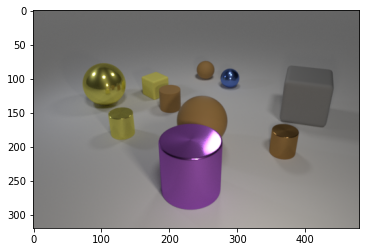

In [84]:
# load image and run inference

img_id = 1
image_filename = f"./GUI_interface/demo_images/image_{img_id}.png"

dataset = 'hans'
image = skimage.io.imread(image_filename)
image = image[:,:,:3]
results = model.detect([image], verbose=0)
r = results[0]

plt.imshow(image)



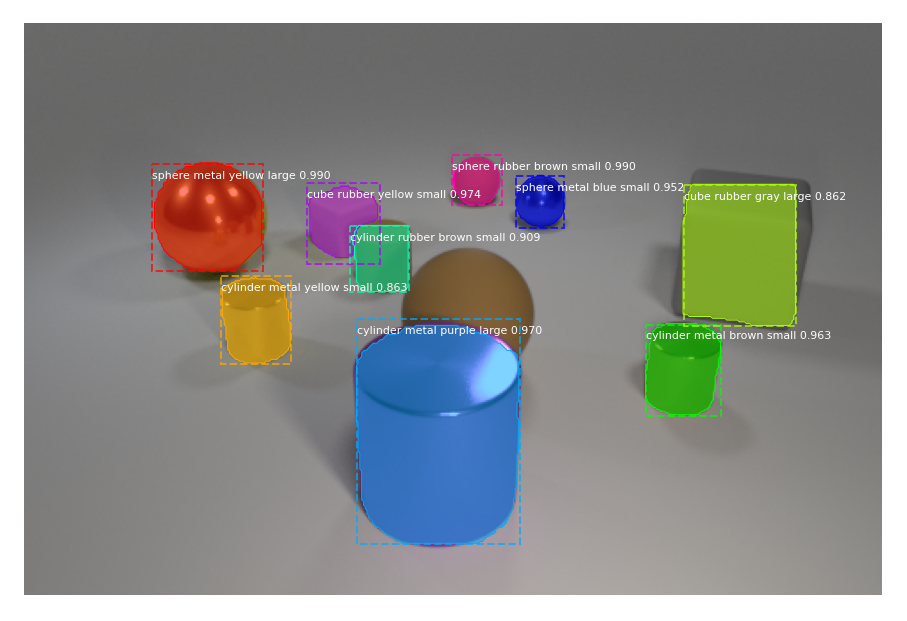

In [85]:
# Formalise general output.
# Do not include ilp class here - as this is for inference.

shape_categories, material_categories, color_categories,\
        size_categories, class_names = define_object_types()
img_objects = ([class_names[r['class_ids'][i]] for i in range(len(r['class_ids']))])

rois = r['rois'].tolist()

# Can ignore for now - we're not using relational predicates in demo yet. 
centroids = {}
centroids['X'] = [(roi[1] + roi[3])/2 for roi in rois]
centroids['Y'] = [(roi[0] + roi[2])/2 for roi in rois]

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [87]:
# Generate program from MRCNN Output

# First generate all possible objects so we can ID them later
attribute_dict = {'color': list(color_categories.keys()), 'material': list(material_categories.keys()),
                        'size': list(size_categories.keys()), 'shape': list(shape_categories.keys())}

full_oblist = get_all_objects(attribute_dict)

# create test file if doesn't already exist and open
if not os.path.exists('test_samples.pl'):
    bk_file = open(f"aleph_input/{dataset}_aleph.bk",'a')
    bk_file.write(f":-consult('test_samples.pl').\n\n")
    bk_file.close()

test_file = open(f"test_samples.pl",'a+')
# bk_file.write("\n")

# generate an example_id - maybe via the image number provided
example_id = str(int(img_id) + 100)

# add image objects contained

for object in img_objects:
    shape, material, color, size = object.split()

    # find the index id of the object recognised
    object_idx = full_oblist.index([shape, material, color, size])
    object_id = f'oid_{object_idx}'
    test_file.write(f"contains({object_id}, example_{example_id}).\n")

test_file.close()

In [83]:
dataset = 'hans'
prolog = Prolog()

result = single_instance_inference(dataset=dataset, example_number=101, prolog=prolog)
pred, explanation = result

if explanation:
    explanation = transform_clause(explanation)

pred, explanation

(1,
 'Image contains an object oid_1 with shape cube and color gray.\nImage contains an object oid_93 with shape cylinder. ')